In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Dataset import *
from Metric import *
from Model import *
from Preprocess import *
from train import *
from tqdm.auto import trange
import torch.nn.functional as F
import torch

/home/jihye/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = pd.read_csv("data/final.csv")

data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
data.head()
m_data = data.copy()
m2_data = data.copy()
patch_data = data.copy()


In [4]:
tst_size = 100
trn, tst = data[1000:-tst_size], data[-tst_size:]

## Stateful Lstm

In [ ]:
# 변수 초기화
#Lstm
state_input_size = 2     #고정
state_hidden_size = 64
state_output_size = 2     #고정
state_num_layers = 2
state_batch_size = 128

In [ ]:
statefullstm = StatefulLoadData(data,tst_size)
state_trn_scaled, state_tst_scaled = statefullstm.scaling()
#trn_scaled, tst_scaled

In [ ]:
statefulmodel = StatefulLSTM(state_input_size,state_hidden_size,state_output_size,state_num_layers)
statefulmodel.to(device)

In [ ]:
trn_x = torch.tensor(state_trn_scaled[:-1]).split(state_batch_size)
trn_y = torch.tensor(state_trn_scaled[1:]).split(state_batch_size)
tst_y = torch.tensor(state_tst_scaled)

In [ ]:
print(trn_y[0])

In [ ]:
state_optim = torch.optim.AdamW(statefulmodel.parameters(), lr=0.0001)
p=state_train_epoch(statefulmodel, 1000 , device, zip(trn_x,trn_y), state_optim, tst_y)
#map , filter, zip

In [ ]:
scaler = statefullstm.get_scaler()
prd = scaler.inverse_transform(p.cpu()[:,:1])

In [ ]:
plt.title(f"LSTM (Stateful), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.Temperature.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

In [ ]:
torch.save(statefulmodel.state_dict(), 'model/AdamW_0.0001_2_64_2_2_StatefulLstm.pth')

# Stateless Lstm

In [ ]:
stateless_window_size = 32
stateless_input_size = 2
stateless_hidden_size = 64
stateless_output_size = 2
stateless_num_layers = 2

asdf = StatelessLoadData(data, tst_size, stateless_window_size)
stateless_trn_dl , stateless_tst_dl = asdf.scaling()

In [ ]:
statelesslstm = StatelessLSTM(stateless_input_size , stateless_hidden_size , stateless_output_size , stateless_num_layers)
statelesslstm.to(device)

In [ ]:
x,y =next(iter(stateless_trn_dl))
x.shape,y.shape

In [ ]:
optim = torch.optim.AdamW(statelesslstm.parameters(), lr=0.0001)
p2 = stateless_train_epoch(statelesslstm,200,device,stateless_trn_dl,optim,stateless_tst_dl, state_tst_scaled)

In [ ]:
for name, param in statelesslstm.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
scaler = asdf.get_scaler()
prd = scaler.inverse_transform(p2.cpu())
# prd = p.cpu()

plt.title(f"LSTM (Look-back window), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.to_numpy()[:,:1], label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

In [ ]:
torch.save(statelesslstm, 'AdamW_0.0001_32_2_32_2_2_StatelessLstm2222222.pth')

# Single ANN

In [ ]:
# dataset params
single_lookback_size = 80
single_forcast_size = 20
single_batch_size = 32

# model params
single_d_in = single_lookback_size
single_d_out = single_forcast_size 
single_d_hidden = 512

anndataset = ANNLoadData(m_data,single_lookback_size,single_forcast_size,tst_size,single_batch_size)

single_trn_dl , single_tst_dl, single_trn_ds = anndataset.scaling()

In [ ]:
singleann = Net(single_d_in,single_d_out,single_d_hidden)

In [ ]:
x, y = next(iter(single_trn_dl))

x.shape, y.shape

In [ ]:
singleann.to(device)
optim = torch.optim.AdamW(singleann.parameters(), lr=0.0001)
p3 = train_epoch(singleann , 2000 , device, single_trn_dl, optim, single_trn_ds, single_tst_dl)

In [ ]:
singleann.eval()
with torch.inference_mode():
  x, y = next(iter(single_tst_dl))
  x, y = x.to(device), y.to(device)
  p = singleann(x)

scaler = anndataset.get_scaler()
y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

res_dict = {}

plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(80,512,20)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

In [ ]:
# 장기예측
window_size = single_lookback_size
prediction_size = single_forcast_size
preds = []
tst_data  = data [-tst_size :]

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
singleann.to(device)

# print(type(x), type(y))
x, y = single_trn_ds[len(single_trn_ds)-1]

for _ in range(tst_size):
  #print(x.shape, y.shape)
  y=y.squeeze()
  #print(x.shape, y.shape)

  x = np.concatenate([x,y])[-window_size:]
  #x = x.flatten()
  #y = y.flatten()
    
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  #y = net(torch.tensor(x, dtype=torch.float32).to(device)) # your model
  y=singleann(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)

preds = np.concatenate(preds, axis=0)
preds = scaler.inverse_transform(preds).squeeze()
#print(preds.shape)
preds = preds[:,0]
#print(preds.shape)

mape2 = mape(preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": preds}, index=tst_data.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

## 통으로 뽑기

In [ ]:
m_data[-single_lookback_size-tst_size:-tst_size]

In [ ]:
single_all = m_data[-single_lookback_size-tst_size:-tst_size]
single_all = single_all.to_numpy()
single_tensor = torch.tensor(single_all, dtype=torch.float32).to(device)
single_tensor = single_tensor.squeeze()
singley = singleann(single_tensor)

In [ ]:
singley = singley.detach().cpu().numpy()

In [ ]:
singley.shape

In [ ]:
singley = singley.reshape(single_forcast_size,1)
single_scaler = anndataset.get_scaler()
singley = single_scaler.inverse_transform(singley).squeeze()

In [ ]:
mape2 = mape(singley,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(singley,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(singley,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
#plt.title(f"PatchTST (extended dataset), MAPE:{mape(preds,data.Temperature[-20:].to_numpy()):.4f}, MAE:{mae(preds,data.Temperature[-20:].to_numpy()):.4f}, R2:{r2_score(preds,data.Temperature[-20:].to_numpy())(p,y):.4f}")
df = pd.DataFrame({"Patch_long": singley}, index=tst.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

In [ ]:
torch.save(singleann.state_dict(), 'model/singlechannel_AdamW_2000_lookback80_forecast20.pth')

# Multichannel ANN

In [ ]:
#Multi Load Data
multi_lookback_size = 80
multi_forecast_size = 20
multi_batch_size = 32

# Multi model
multi_input_size = multi_lookback_size   #고정
multi_hidden_size = 512
multi_output_size = multi_forecast_size     #고정
multi_channel_size = 4

In [ ]:
#m_data = data.copy()
m2_data['rolling_mean'] = m2_data.rolling(12).mean()
m2_data['rolling_mean2'] = m2_data['Temperature'].rolling(4).mean()
m2_data['diff1'] = m2_data['Temperature'].diff(1)
m2_data = m2_data.dropna()

multidata = MultiANNLoadData(m2_data,multi_lookback_size,multi_forecast_size,tst_size,multi_batch_size)
multi_trn_dl, multi_tst_dl , multi_trn_ds = multidata.scaling()

In [ ]:
multimodel = NetMulti(multi_lookback_size,multi_output_size,multi_hidden_size,multi_channel_size)

- 40개월   ex) 60을 보고 40을 예측  /  1개월씩 40을 예측  /  4개월씩 10번
- 목표를 설정하고 그것을 이루기 위해 시도한 방법들 소개!

In [ ]:
multimodel.cuda()

optim = torch.optim.Adam(multimodel.parameters(), lr=0.00001)
train_epoch(multimodel,500,device,multi_trn_dl,optim,multi_trn_ds, multi_tst_dl)

In [ ]:
#torch.save(multimodel, 'model/3channel_AdamW_2000_lookback80_forecast20_multichannel.pth')
torch.save(multimodel.state_dict(), 'model0112/1000cut_test20_4channel_Adam_300_lookback80_forecast20_multichannel_dict.pth')


# 단기

In [ ]:
scaler = multidata.get_scaler()

multimodel.eval()
multimodel.to('cuda')
with torch.inference_mode():
  x, y = next(iter(multi_tst_dl))
  #print(y.shape) #17,4,3
  y=y.reshape(-1,multi_channel_size)
  y=scaler.inverse_transform(y.cpu().numpy())
  y=y.reshape(-1,multi_forecast_size,multi_channel_size)
  x, y = x.flatten(1), y[:,:,0] #17,4    0번째 채널을 뽑고있다.

  x = x.to('cuda')
  #p = Multinet(x)[:,:,0]
  p = multimodel(x)
  #print(p)

  #print(p.shape)
  p = p.reshape(-1,multi_channel_size)
  p=p.cpu()
  p=scaler.inverse_transform(p.numpy())
  #print(p.shape)
  p = p.reshape(-1,multi_forecast_size,multi_channel_size)

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])
#print(y,p)
#print(y.shape,p.shape)
p = p[:,0]
#inverse_preds = scaler.inverse_transform(p.reshape(-1,3))


plt.title(f"Multi Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()


# 장기

In [ ]:
# 장기예측
multimodel.eval()
window_size = multi_lookback_size
prediction_size = multi_forecast_size
preds = []
multimodel.to(device)

# print(type(x), type(y))
x2, y2 = multi_trn_ds[len(multi_trn_ds)-1]
#print(y)
#print(x.shape , y.shape)

In [ ]:
preds = []

for i in range(tst_size):
  y2 = y2.squeeze()
  # print(i, x.shape, y.shape)
  x2 = np.concatenate([x2,y2])[-window_size:]
  x_tensor = torch.tensor(x2, dtype=torch.float32).unsqueeze(0).to(device)
  # print(x_tensor.shape)
  y2 = multimodel(x_tensor)
  # print(y.shape)
  y2 = y2.detach().cpu().numpy()
  # y = y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y2)
  # print(i, x.shape, y.shape)

preds = np.concatenate(preds, axis=0)
inverse_preds = scaler.inverse_transform(preds.reshape(-1,multi_channel_size)).reshape(-1,multi_forecast_size,multi_channel_size)

final_preds = inverse_preds[:, 0,0]
print(final_preds.shape)

mape2 = mape(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(final_preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": final_preds}, index=tst.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

## 한번에 뽑아보기

In [ ]:
#multi_scaler = multidata.get_scaler()
multimodel.eval()
#multiall = m2_data[-multi_lookback_size-tst_size-multi_forecast_size:-tst_size-multi_forecast_size]
#multiall = m2_data[-multi_lookback_size-tst_size:-tst_size]
a, b = multi_trn_ds[len(multi_trn_ds)-1]
x2 = np.concatenate([a,b])[-window_size:]
#print(x2)
#multiall = multiall.to_numpy()
multi_tensor = torch.tensor(x2, dtype=torch.float32).unsqueeze(0).to(device)
multiy = multimodel(multi_tensor)

In [ ]:
multiy = multiy.detach().cpu().numpy()

In [ ]:
multiy = multiy.reshape(multi_forecast_size,multi_channel_size)
multiy = scaler.inverse_transform(multiy).squeeze()

In [ ]:
mape2 = mape(multiy[:,0],data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(multiy[:,0],data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(multiy[:,0],data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
#plt.title(f"PatchTST (extended dataset), MAPE:{mape(preds,data.Temperature[-20:].to_numpy()):.4f}, MAE:{mae(preds,data.Temperature[-20:].to_numpy()):.4f}, R2:{r2_score(preds,data.Temperature[-20:].to_numpy())(p,y):.4f}")
df = pd.DataFrame({"Multi-tong": multiy[:,0]}, index=tst.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

# PatchTST

In [5]:
#test_size = 20
#초기화
#patch_size = 4 #고정
#(batch, n_patchs, patch_length)
#근까 patch length가 patch size랑 같은말아님?????
patch_length = 80 #고정
n_patch = 4
#n_token = 64   #조정
patch_batch_size = 32
patch_model_dim = 128 #고정
patch_num_heads = 16   #고정
patch_num_layers = 3   #고정
patch_output_dim = tst_size  #고정

나지금 num_layer 3에서 4로 바꿨다?

In [6]:
patchdata = PatchLoadData(patch_data, n_patch, patch_length, tst_size, patch_batch_size)
patch_trn_dl , patch_tst_dl, patch_trn_ds = patchdata.scaling()

In [7]:
patchmodel = PatchTST(n_patch, patch_length, patch_model_dim, patch_num_heads, patch_num_layers, patch_output_dim)
patchmodel.cuda()

PatchTST(
  (patch_embedding): Linear(in_features=80, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=512, out_features=100, bias=True)
)

In [8]:
optim = torch.optim.Adam(patchmodel.parameters(), lr=0.0001)
train_epoch(patchmodel,700,device,patch_trn_dl,optim,patch_trn_ds, patch_tst_dl)

100%|██████████| 700/700 [06:26<00:00,  1.81it/s, loss=0.000433, tst_loss=0.0246]


tensor([[0.7402, 0.8072, 0.7758, 0.7383, 0.7321, 0.7976, 0.8072, 0.7920, 0.8112,
         0.8323, 0.8015, 0.8286, 0.8127, 0.7942, 0.7927, 0.8183, 0.8077, 0.7557,
         0.7760, 0.7978, 0.7417, 0.7839, 0.7651, 0.7788, 0.7382, 0.7394, 0.8118,
         0.7924, 0.7121, 0.7628, 0.7280, 0.7267, 0.7368, 0.8221, 0.8392, 0.7962,
         0.7686, 0.7432, 0.8006, 0.7897, 0.7230, 0.7965, 0.7682, 0.7866, 0.7803,
         0.7480, 0.8152, 0.8182, 0.8024, 0.7676, 0.8019, 0.8415, 0.7906, 0.7149,
         0.7860, 0.8007, 0.7966, 0.7861, 0.8152, 0.7715, 0.6907, 0.7106, 0.7466,
         0.7691, 0.7251, 0.7679, 0.7532, 0.7860, 0.7942, 0.7931, 0.7478, 0.7839,
         0.7110, 0.7809, 0.7757, 0.8512, 0.7934, 0.7129, 0.8512, 0.7258, 0.7318,
         0.8310, 0.8211, 0.7522, 0.7291, 0.7637, 0.8110, 0.7851, 0.8086, 0.7510,
         0.7681, 0.7842, 0.7960, 0.7226, 0.8000, 0.7519, 0.7579, 0.7117, 0.7828,
         0.8505]], device='cuda:0')

In [9]:
scaler = patchdata.get_scaler()

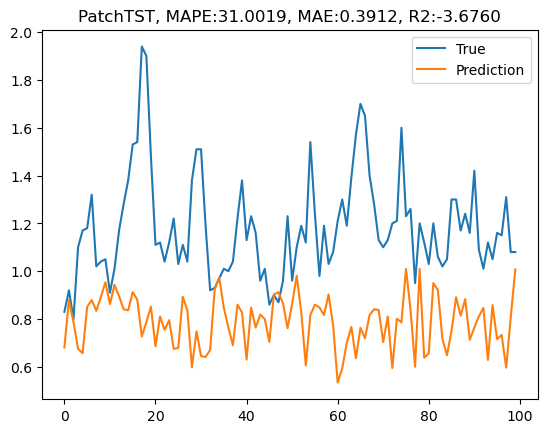

In [10]:


patchmodel.eval()
with torch.inference_mode():
  x, y = next(iter(patch_tst_dl))
  x, y = x.cuda(), y.cuda()
  p = patchmodel(x)

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"PatchTST, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

In [11]:
window_size = int(n_patch * patch_length/2)
eval = trn[-window_size:]
eval = eval.to_numpy()
eval = scaler.transform(eval.reshape(-1, 1))
last8 = eval[-1]
eval = eval.squeeze()
eval_concat = np.concatenate([eval, last8*np.ones(int(patch_length/2),dtype=np.float32)])  

In [12]:
x = np.array([eval_concat[i*int(patch_length/2):(i+2)*int(patch_length/2)] for i in range(n_patch)])  ##dataset

In [13]:
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y=patchmodel(x_tensor)
y

tensor([[0.7402, 0.8072, 0.7758, 0.7383, 0.7321, 0.7976, 0.8072, 0.7920, 0.8112,
         0.8323, 0.8015, 0.8286, 0.8127, 0.7942, 0.7927, 0.8183, 0.8077, 0.7557,
         0.7760, 0.7978, 0.7417, 0.7839, 0.7651, 0.7788, 0.7382, 0.7394, 0.8118,
         0.7924, 0.7121, 0.7628, 0.7280, 0.7267, 0.7368, 0.8221, 0.8392, 0.7962,
         0.7686, 0.7432, 0.8006, 0.7897, 0.7230, 0.7965, 0.7682, 0.7866, 0.7803,
         0.7480, 0.8152, 0.8182, 0.8024, 0.7676, 0.8019, 0.8415, 0.7906, 0.7149,
         0.7860, 0.8007, 0.7966, 0.7861, 0.8152, 0.7715, 0.6907, 0.7106, 0.7466,
         0.7691, 0.7251, 0.7679, 0.7532, 0.7860, 0.7942, 0.7931, 0.7478, 0.7839,
         0.7110, 0.7809, 0.7757, 0.8512, 0.7934, 0.7129, 0.8512, 0.7258, 0.7318,
         0.8310, 0.8211, 0.7522, 0.7291, 0.7637, 0.8110, 0.7851, 0.8086, 0.7510,
         0.7681, 0.7842, 0.7960, 0.7226, 0.8000, 0.7519, 0.7579, 0.7117, 0.7828,
         0.8505]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
y = y.detach().cpu().numpy()
scaler = patchdata.get_scaler()
preds = scaler.inverse_transform(y).squeeze()

In [ ]:
# 장기예측 plot
#plt.title(f"PatchTST (extended dataset), MAPE:{mape(preds,data.Temperature[-20:].to_numpy()):.4f}, MAE:{mae(preds,data.Temperature[-20:].to_numpy()):.4f}, R2:{r2_score(preds,data.Temperature[-20:].to_numpy())(p,y):.4f}")
df = pd.DataFrame({"Patch_long": preds}, index=tst.index)
plt.title(f"PatchTST-single, MAPE:{mape(preds,data.Temperature[-tst_size:].to_numpy()):.4f}, MAE:{mae(preds,data.Temperature[-tst_size:].to_numpy()):.4f}, R2:{r2_score(preds,data.Temperature[-tst_size:].to_numpy()):.4f}")
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

In [ ]:
torch.save(patchmodel.state_dict(), 'tst_size(100)_front_1000numlayer4Adam_single8020_patchTST.pth')

# rolling_mean 채널 붙이기

In [14]:
m_data['rolling_mean'] = data.Temperature.rolling(12).mean()
m_data['diff1'] = data.Temperature.diff(1)
m_data = m_data.dropna()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
trn2_scaled = scaler2.fit_transform(m_data['rolling_mean'][:-tst_size].to_numpy(dtype=np.float32).reshape(-1,1)).flatten()
trn3_scaled = scaler3.fit_transform(m_data['diff1'][:-tst_size].to_numpy(dtype=np.float32).reshape(-1,1)).flatten()

trn2_ds = PatchTSDataset(trn2_scaled, patch_length, n_patch, tst_size)
trn3_ds = PatchTSDataset(trn3_scaled, patch_length, n_patch, tst_size)

trn4_ds = torch.utils.data.ConcatDataset([patch_trn_ds, trn2_ds, trn3_ds])

trn_dl4 = torch.utils.data.DataLoader(trn4_ds, batch_size=32, shuffle=True)

In [15]:
patchmodel2 = PatchTST(n_patch, patch_length, patch_model_dim, patch_num_heads, patch_num_layers, patch_output_dim)
patchmodel2.cuda()

PatchTST(
  (patch_embedding): Linear(in_features=80, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=512, out_features=100, bias=True)
)

In [16]:
optim = torch.optim.Adam(patchmodel2.parameters(), lr=0.0001)
train_epoch(patchmodel2,500,device,trn_dl4,optim,trn4_ds, patch_tst_dl)

100%|██████████| 500/500 [10:28<00:00,  1.26s/it, loss=0.00051, tst_loss=0.0194] 


tensor([[0.7716, 0.8270, 0.8157, 0.8104, 0.7632, 0.8125, 0.8119, 0.8368, 0.8343,
         0.8221, 0.8386, 0.7711, 0.7849, 0.8204, 0.8288, 0.8157, 0.8284, 0.7913,
         0.7870, 0.8065, 0.7884, 0.8229, 0.7704, 0.7934, 0.7937, 0.7754, 0.8382,
         0.8157, 0.7701, 0.8125, 0.8240, 0.7938, 0.7944, 0.7895, 0.8020, 0.7847,
         0.7504, 0.7814, 0.7580, 0.7908, 0.8096, 0.7816, 0.7534, 0.8266, 0.8098,
         0.7999, 0.8516, 0.8215, 0.8040, 0.7967, 0.8230, 0.8426, 0.7729, 0.7652,
         0.8184, 0.7848, 0.8163, 0.7932, 0.8243, 0.7524, 0.7895, 0.7587, 0.7863,
         0.8405, 0.7782, 0.7708, 0.7394, 0.7597, 0.7779, 0.8168, 0.8042, 0.8009,
         0.7587, 0.7195, 0.7616, 0.8644, 0.7917, 0.7670, 0.7968, 0.7544, 0.8032,
         0.8005, 0.8218, 0.7895, 0.7270, 0.7912, 0.8594, 0.8020, 0.8244, 0.7967,
         0.7576, 0.7888, 0.7596, 0.7964, 0.8193, 0.7844, 0.7572, 0.7818, 0.7705,
         0.8369]], device='cuda:0')

In [17]:
scaler = patchdata.get_scaler()
y=patchmodel2(x_tensor)
y = y.detach().cpu().numpy()
preds2 = scaler.inverse_transform(y).squeeze()

MAPE:  26.804430252354315
MAE:  0.34114028565883636
R2_Score:  -2.684559529918117


<Axes: title={'center': 'PatchTSTextended, MAPE:26.8044, MAE:0.3411, R2:-2.6846'}, xlabel='YearMonth'>

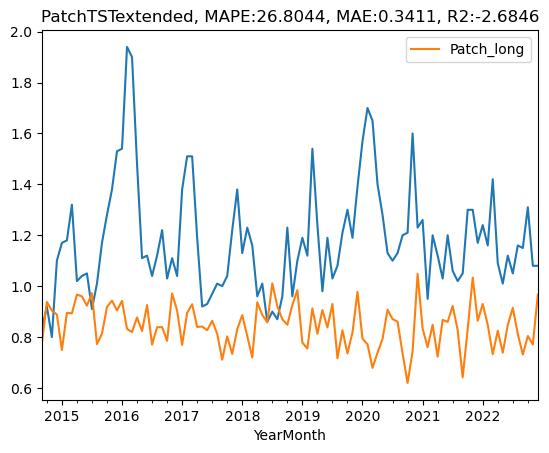

In [18]:
mape2 = mape(preds2,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds2,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds2,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
plt.title(f"PatchTSTextended, MAPE:{mape(preds2,data.Temperature[-tst_size:].to_numpy()):.4f}, MAE:{mae(preds2,data.Temperature[-tst_size:].to_numpy()):.4f}, R2:{r2_score(preds2,data.Temperature[-tst_size:].to_numpy()):.4f}")
df = pd.DataFrame({"Patch_long": preds2}, index=tst.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

In [19]:
torch.save(patchmodel2.state_dict(), 'tst_size(100)_front1000Adam_multi164_patchTST_layer4_compare.pth')